In [1]:
# Data processing
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import Series

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#model
from prophet import Prophet
import random
from sklearn.linear_model import LinearRegression


/home/zelie/.pyenv/versions/3.10.6/envs/favorita/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Data import

In [2]:
#data import
df_main = pd.read_csv('df_main_v4.csv')

#group by date
df = df_main.groupby(by='date').agg({'sales': 'sum','onpromotion':'sum', 'dcoilwtico':'mean'})

#Round the price of the oil
df['dcoilwtico']=df['dcoilwtico'].astype('int64')

#reset index
df.reset_index(inplace=True)

# Data exploration

In [3]:
#adding temporal data
df['date'] = pd.to_datetime(df['date'])
df['week_day'] = df["date"].dt.day_name()
df['month']= df['date'].dt.strftime('%B')
df['année']= df['date'].dt.strftime('%Y')
df['quarter'] = df['date'].dt.quarter


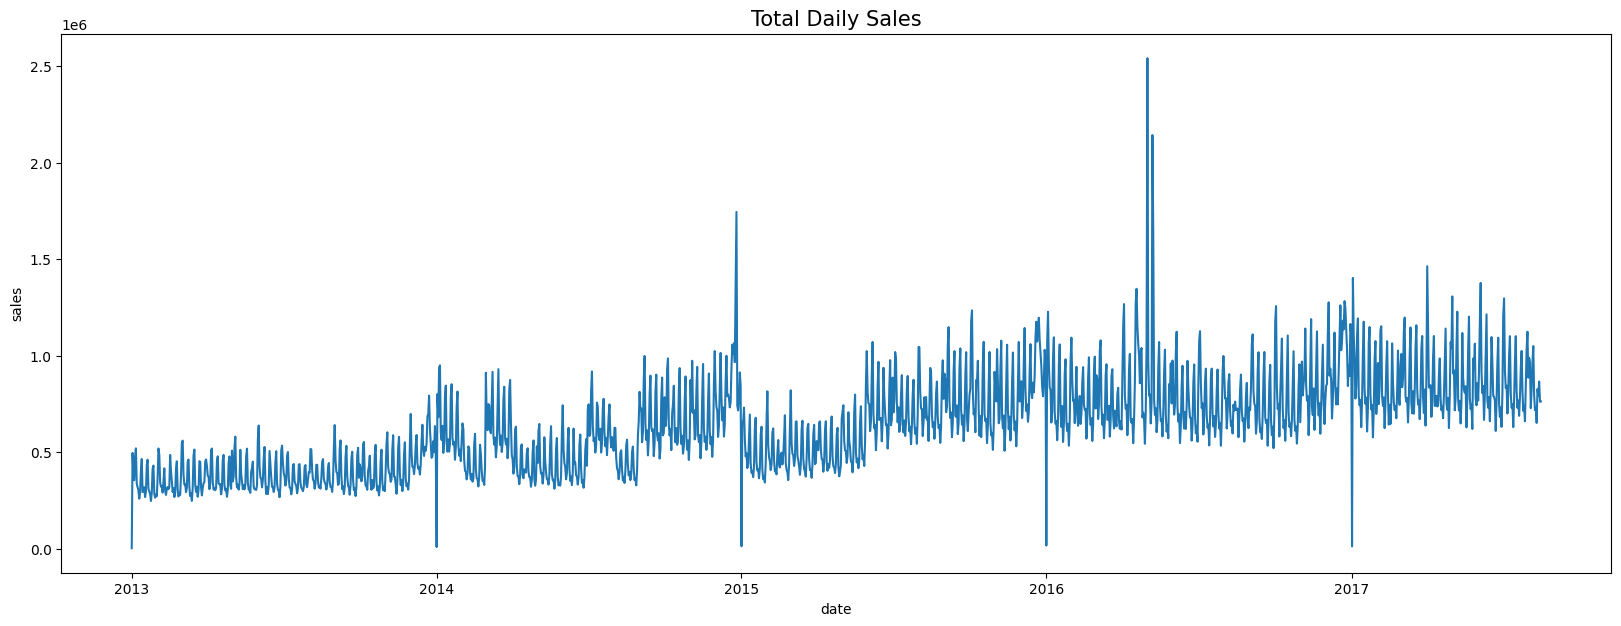

In [4]:
#Total daily sales
fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="date", y="sales", data=df)
a.set_title("Total Daily Sales",fontsize=15)
plt.show()

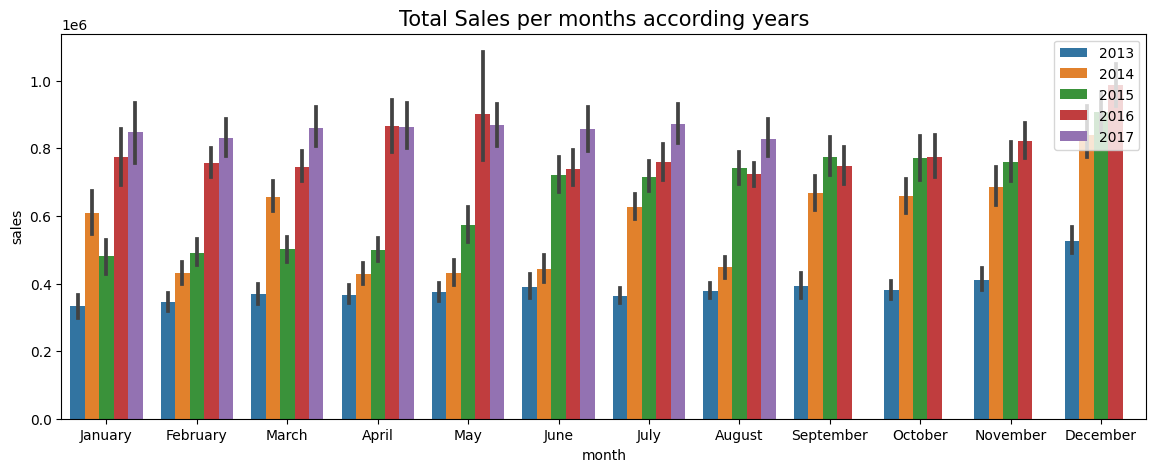

In [5]:
#Total Monthly Sales
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="sales",data=df,hue = 'année',)
a.set_title("Total Sales per months according years",fontsize=15)
plt.legend(loc='upper right')
plt.show()

Text(0.5, 1.0, 'Total Sales By year')

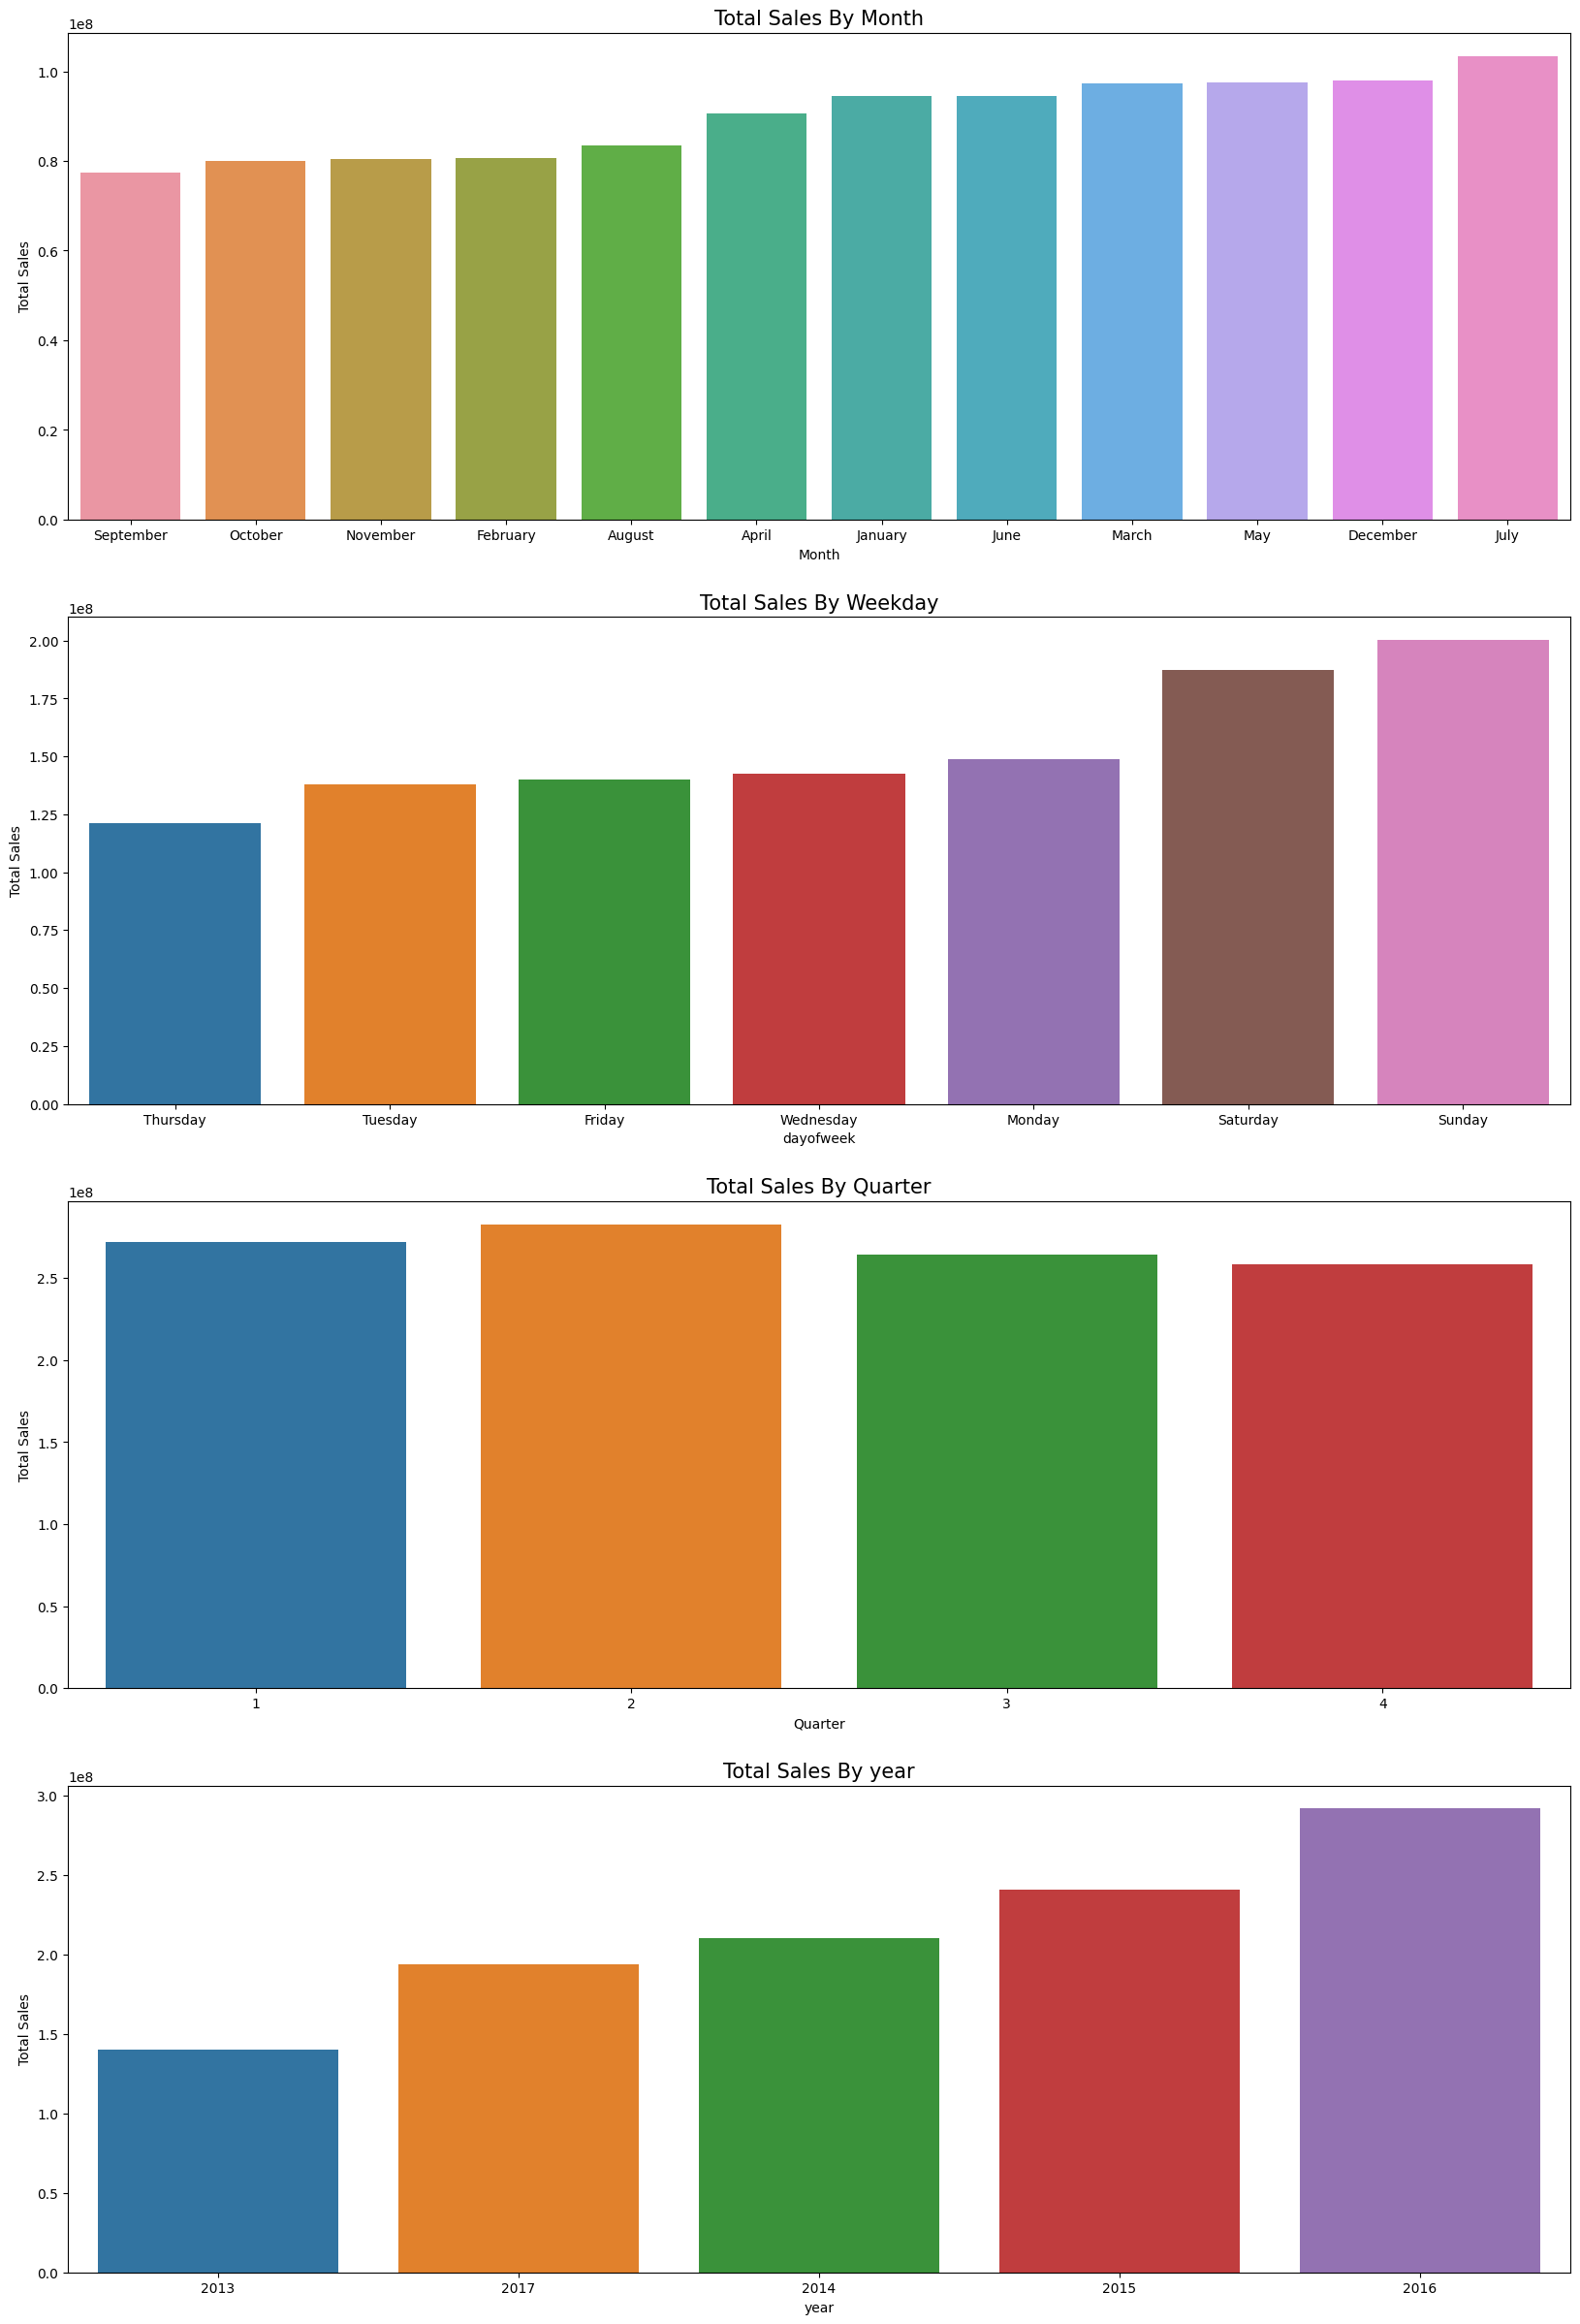

In [6]:
#
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,30)

monthAggregated = pd.DataFrame(df.groupby("month")["sales"].sum()).reset_index().sort_values('sales')
sns.barplot(data=monthAggregated,x="month",y="sales",ax=ax1)
ax1.set(xlabel='Month', ylabel='Total Sales')
ax1.set_title("Total Sales By Month",fontsize=15)

monthAggregated = pd.DataFrame(df.groupby("week_day")["sales"].sum()).reset_index().sort_values('sales')
sns.barplot(data=monthAggregated,x="week_day",y="sales",ax=ax2)
ax2.set(xlabel='dayofweek', ylabel='Total Sales')
ax2.set_title("Total Sales By Weekday",fontsize=15)

monthAggregated = pd.DataFrame(df.groupby("quarter")["sales"].sum()).reset_index().sort_values('sales')
sns.barplot(data=monthAggregated,x="quarter",y="sales",ax=ax3)
ax3.set(xlabel='Quarter', ylabel='Total Sales')
ax3.set_title("Total Sales By Quarter",fontsize=15)

monthAggregated = pd.DataFrame(df.groupby("année")["sales"].sum()).reset_index().sort_values('sales')
sns.barplot(data=monthAggregated,x="année",y="sales",ax=ax4)
ax4.set(xlabel='year', ylabel='Total Sales')
ax4.set_title("Total Sales By year",fontsize=15)

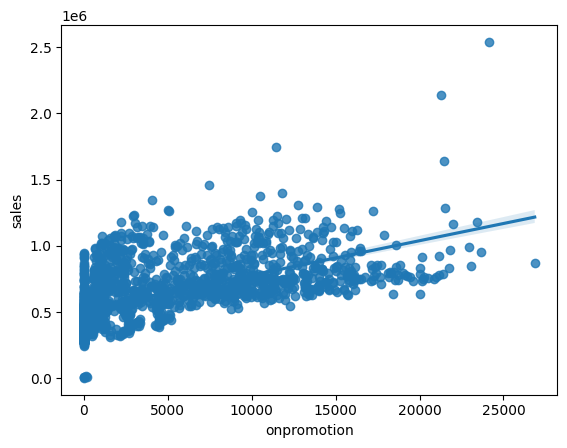

In [7]:
#regression promotion sale
sns.regplot(df,x='onpromotion',y='sales');

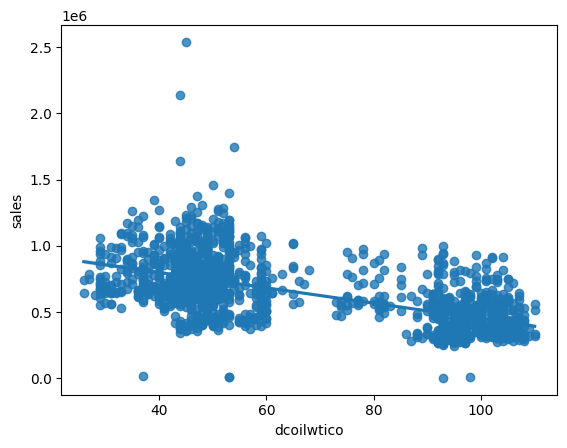

In [8]:
#regression oil sale
sns.regplot(df,x='dcoilwtico',y='sales');

# Baseline score

In [9]:
#fonctions baseline score with Prophet
def drop_rename_columns(df):
    """Keep only useful columns for Prophet forecast"""
    df = df[['date', 'sales']]
    df.rename(columns={'date': 'ds', 'sales':'y'}, inplace=True)
    return df

def split_train_test(df):
    """split a dataframe to have train and test value"""
    df_train = df[df['ds']<'2017-04-01']
    df_train.reset_index(drop = True, inplace = True)
    df_test = df[(df['ds']>='2017-04-01')&(df['ds']<'2017-07-01')]
    df_test.reset_index(drop = True, inplace = True)
    return (df_train, df_test)

def forecast_with_Prophet(df_train):
    """Make Prophet forecast"""
    m=Prophet()
    m.fit(df_train)
    future = m.make_future_dataframe(periods=91)
    forecast = m.predict(future)
    return forecast

def MAPE_of_forecast(forecast, df_test):
    """Compute MAPE between forecasted values and actual data"""
    forecast_only = forecast[(forecast['ds']>='2017-04-01')&(forecast['ds']<'2017-07-01')]
    forecast_only.reset_index(drop = True, inplace = True)
    return MAPE(forecast_only['yhat'], df_test['y'])

def MAPE(y_pred, y_true):
    """Compute the MAPE between two vectors: our prediction and the actual value""" 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
   

def get_baseline_score(df):
    """Re-use all the functions above to directly compute a baseline score of a given dataframe"""
    clean_df = drop_rename_columns(df)
    df_train=split_train_test(clean_df)[0]
    df_test=split_train_test(clean_df)[1]
    forecast=forecast_with_Prophet(df_train)
    return MAPE_of_forecast(forecast, df_test)

In [10]:
df_new = drop_rename_columns(df)
df_train, df_test = split_train_test(df_new)
forecast = forecast_with_Prophet(df_train)
baseline_score = MAPE_of_forecast(forecast, df_test)
baseline_score

/tmp/ipykernel_26983/3115077518.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'date': 'ds', 'sales':'y'}, inplace=True)
11:48:36 - cmdstanpy - INFO - Chain [1] start processing
11:48:36 - cmdstanpy - INFO - Chain [1] done processing


7.718925394705596

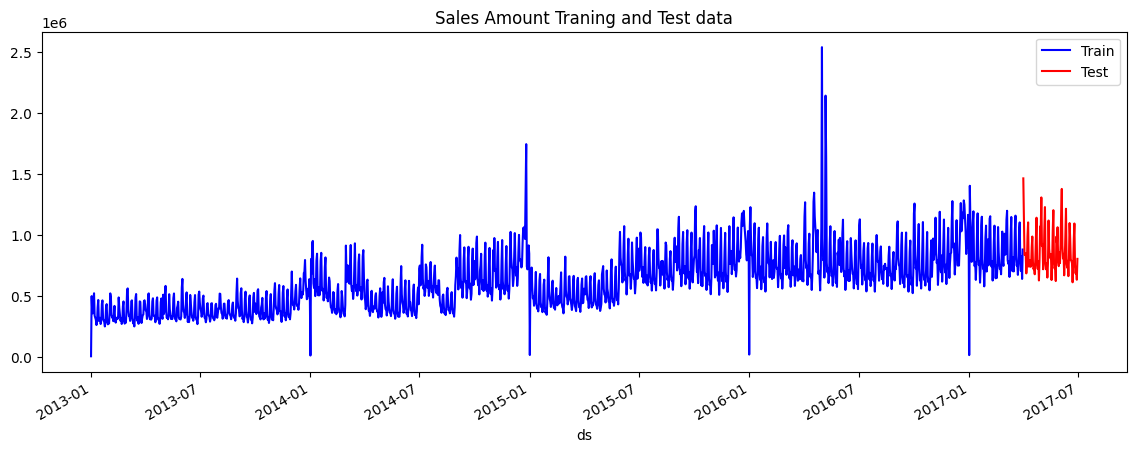

In [11]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
df_train.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
df_test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Sales Amount Traning and Test data')
plt.show()

# Hyperparameter Tuning 

## Add holidays

In [12]:
#Nationnal holiday database
nat_bh = df_main[['date','holidays_nat']].groupby('date').mean()
nat_bh = nat_bh[(nat_bh['holidays_nat']==1)]
nat_bh.reset_index(inplace=True)

#Data preparation for prophet
nat_bh.rename(columns={"date":'ds','holidays_nat':'holiday'},inplace=True)
nat_bh.replace(1.0,'Nat BH',inplace=True)
df_bh_train, df_bh_test = split_train_test(nat_bh)

In [13]:
#Model with holidays
model_with_holidays = Prophet(holidays=df_bh_train)
model_with_holidays.fit(df_train)
future = model_with_holidays.make_future_dataframe(periods=91, freq='D')
forecast = model_with_holidays.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(91)
r_holidays = MAPE_of_forecast(forecast, df_test)
r_holidays

/home/zelie/.pyenv/versions/3.10.6/envs/favorita/lib/python3.10/site-packages/prophet/forecaster.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:48:37 - cmdstanpy - INFO - Chain [1] start processing
11:48:38 - cmdstanpy - INFO - Chain [1] done processing


7.78155763664507

la MAPE est pire avec les holidays nationnaux

## Gridsearch

In [14]:
#ameliorer les hyperparams
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.05,0.36,0.4],
               'seasonality_prior_scale':[0.01,0.1,1,2,5,6,8,10],
              'holidays_prior_scale':[0.46,0.5,10],
              'n_changepoints' : [25,90,100,110],
              }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 576


In [15]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
strt='2013-01-01'
end='2017-04-01'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=df_bh_train, 
                         interval_width=0.95)
    train_model.fit(df_train)
    train_forecast = train_model.make_future_dataframe(periods=91, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    #Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    MAPE = mean_absolute_percentage_error(df_test['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

In [17]:
#Meilleur params
# parameters = model_parameters.sort_values(by=['MAPE'])
# parameters = parameters.reset_index(drop=True)
# best_params = parameters['Parameters'][0]
# best_params

In [18]:
model_tunned = Prophet(changepoint_prior_scale=0.05,
                       holidays_prior_scale=0.5,
                     n_changepoints=100, 
                    seasonality_prior_scale=2,
                      seasonality_mode='multiplicative')
model_tunned.fit(df_train)
future = model_tunned.make_future_dataframe(periods=91, freq='D')
forecast = model_tunned.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(91)
r_tunned = MAPE_of_forecast(forecast, df_test)
r_tunned

11:48:39 - cmdstanpy - INFO - Chain [1] start processing
11:48:39 - cmdstanpy - INFO - Chain [1] done processing


7.754078272312771

In [19]:
# Plot the components of the model
#fig = model_tunned.plot_components(forecast,weekly_start=1)

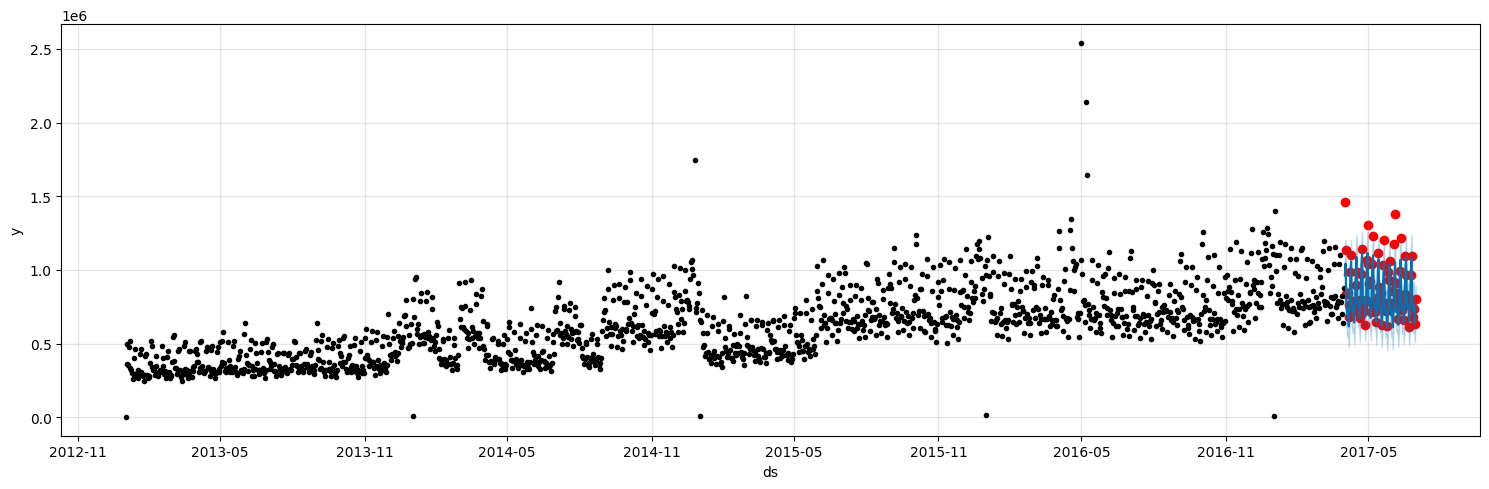

In [20]:
df_test_forecast = model_tunned.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.ds, df_test['y'], color='r')
fig = model_tunned.plot(df_test_forecast, ax=ax)

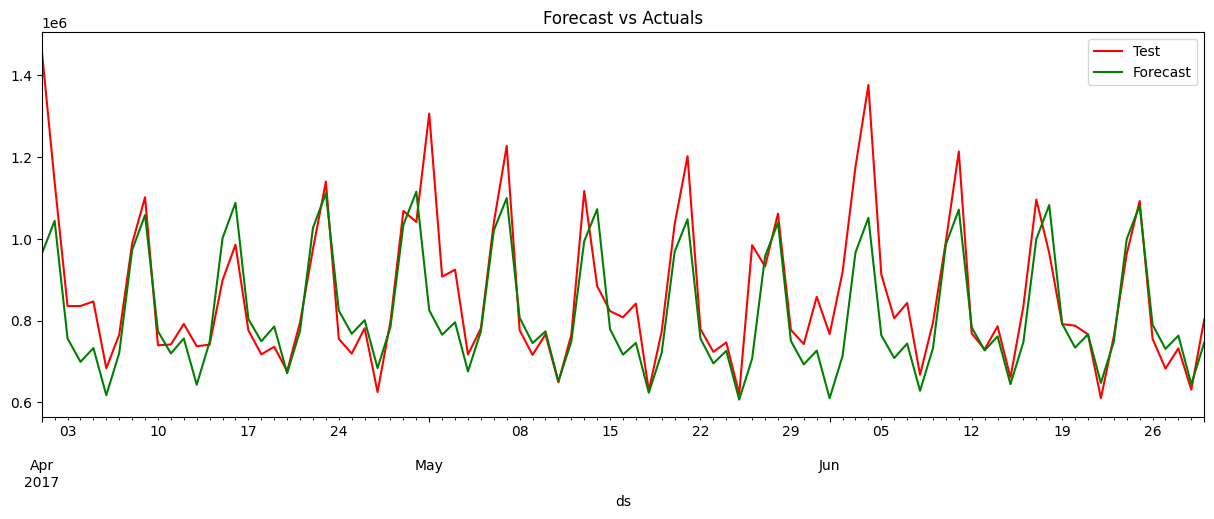

In [21]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [22]:
#add seasonnality to basic model
model_season = Prophet()
model_season.add_seasonality(period=30.417, name='monthly', fourier_order=10)
model_season.fit(df_train)
future = model_season.make_future_dataframe(periods=91, freq='D')
forecast = model_season.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(91)
r_season = MAPE_of_forecast(forecast, df_test)
r_season

11:48:40 - cmdstanpy - INFO - Chain [1] start processing
11:48:41 - cmdstanpy - INFO - Chain [1] done processing


6.907552723921846

In [23]:
#add regressor on oil on the 
df_oil = df_main.groupby('date').mean()
df_oil.reset_index(inplace=True)
df_oil = df[['date','dcoilwtico']]
df_oil.rename(columns={'date': 'ds'}, inplace=True)

/tmp/ipykernel_26983/1049128350.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_oil = df_main.groupby('date').mean()
/tmp/ipykernel_26983/1049128350.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oil.rename(columns={'date': 'ds'}, inplace=True)


In [24]:
df_train_bis = df_train.merge(df_oil,on='ds',how='left')

In [25]:
df_test_bis = df_test.merge(df_oil,on='ds',how='left')

In [26]:
df_test_bis["dcoilwtico"].unique()

array([50, 51, 52, 53, 49, 48, 47, 45, 46, 44, 43, 42])

In [27]:
df_train_bis['dcoilwtico'].unique()
df_train_bis

,ds,y,dcoilwtico
0,2013-01-01,2511.618999,93
1,2013-01-02,496092.417944,93
2,2013-01-03,361461.231124,92
3,2013-01-04,354459.677093,93
4,2013-01-05,477350.121229,93
...,...,...,...
1542,2017-03-27,784103.265042,47
1543,2017-03-28,702943.948577,48
1544,2017-03-29,824632.985033,49
1545,2017-03-30,637624.340998,50


In [28]:
#add regressor on oil to basic model
model_season_oil = Prophet()
model_season_oil.add_regressor('dcoilwtico',prior_scale=0.4)
model_season_oil.add_seasonality(period=30.5, name='monthly', fourier_order=10)
model_season_oil.fit(df_train_bis)
future = model_season_oil.make_future_dataframe(periods=91, freq='D')
future.insert(1, 'dcoilwtico',df_oil["dcoilwtico"])
future
forecast = model_season_oil.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(91)
r_season = MAPE_of_forecast(forecast, df_test_bis)
r_season

11:48:42 - cmdstanpy - INFO - Chain [1] start processing
11:48:42 - cmdstanpy - INFO - Chain [1] done processing


8.397130835548229

In [29]:
#add promo
df_promo = df_main[['date','onpromotion']]
df_promo = df_promo.groupby('date').sum()
df_promo = df_promo[(df_promo['onpromotion']>0)]
df_promo.reset_index(inplace=True)
df_promo.rename(columns={'date': 'ds','onpromotion':'holiday'}, inplace=True)
df_promo['ds'] = pd.to_datetime(df_promo['ds'])

In [30]:
df_promo_train, df_promo_test = split_train_test(df_promo)
df_promo_train['holiday'] =df_promo_train['holiday'].astype('str')

/tmp/ipykernel_26983/2093943055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_promo_train['holiday'] =df_promo_train['holiday'].astype('str')


In [31]:
#add promo to basic model
model_prom = Prophet(holidays=df_promo_train)
model_prom.add_seasonality(period=30.5, name='monthly', fourier_order=10)
model_prom.fit(df_train)
future = model_prom.make_future_dataframe(periods=91, freq='D')
forecast = model_prom.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(91)
r_promo = MAPE_of_forecast(forecast, df_test)
r_promo

/home/zelie/.pyenv/versions/3.10.6/envs/favorita/lib/python3.10/site-packages/prophet/forecaster.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:48:45 - cmdstanpy - INFO - Chain [1] start processing
11:49:00 - cmdstanpy - INFO - Chain [1] done processing


10.394029685178383

In [32]:
 #April 16, 2016

In [33]:
df_main = df_main.groupby(by='date').sum()
df_main.reset_index(inplace=True)

/tmp/ipykernel_26983/3934156928.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_main = df_main.groupby(by='date').sum()


In [41]:
df_events = df_main[(df_main['date']>='2016-04-15') & (df_main['date']<'2016-04-17')]
df_events

,date,id,store_nbr,sales,onpromotion,holidays,holidays_nat,is_holiday,dcoilwtico
1197,2016-04-15,3802689099,49005,667606.299867,9158,0,0,0,71992.8
1198,2016-04-16,3805864623,49005,862121.492036,3954,0,1782,1782,71992.8


In [42]:
df_events['event'] = 'tremblement'

/tmp/ipykernel_26983/2964958388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['event'] = 'tremblement'


df_events

In [43]:
df_events = df_events[['date','event']]
df_events


,date,event
1197,2016-04-15,tremblement
1198,2016-04-16,tremblement


In [46]:
df_events.rename(columns={'date': 'ds','event':'holiday'}, inplace=True)
df_events

/tmp/ipykernel_26983/806101116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events.rename(columns={'date': 'ds','event':'holiday'}, inplace=True)


,ds,holiday
1197,2016-04-15,tremblement
1198,2016-04-16,tremblement


In [48]:
df_events['ds'] = pd.to_datetime(df_events['ds'])
df_events

/tmp/ipykernel_26983/3970667790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['ds'] = pd.to_datetime(df_events['ds'])


,ds,holiday
1197,2016-04-15,tremblement
1198,2016-04-16,tremblement


In [49]:
#add tremblement to basic model
model_prom = Prophet(holidays=df_events)
model_prom.add_seasonality(period=30.417, name='monthly', fourier_order=10)
model_prom.fit(df_train)
future = model_prom.make_future_dataframe(periods=91, freq='D')
forecast = model_prom.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(91)
r_promo = MAPE_of_forecast(forecast, df_test)
r_promo

/home/zelie/.pyenv/versions/3.10.6/envs/favorita/lib/python3.10/site-packages/prophet/forecaster.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:52:00 - cmdstanpy - INFO - Chain [1] start processing
11:52:00 - cmdstanpy - INFO - Chain [1] done processing


6.909450285581401

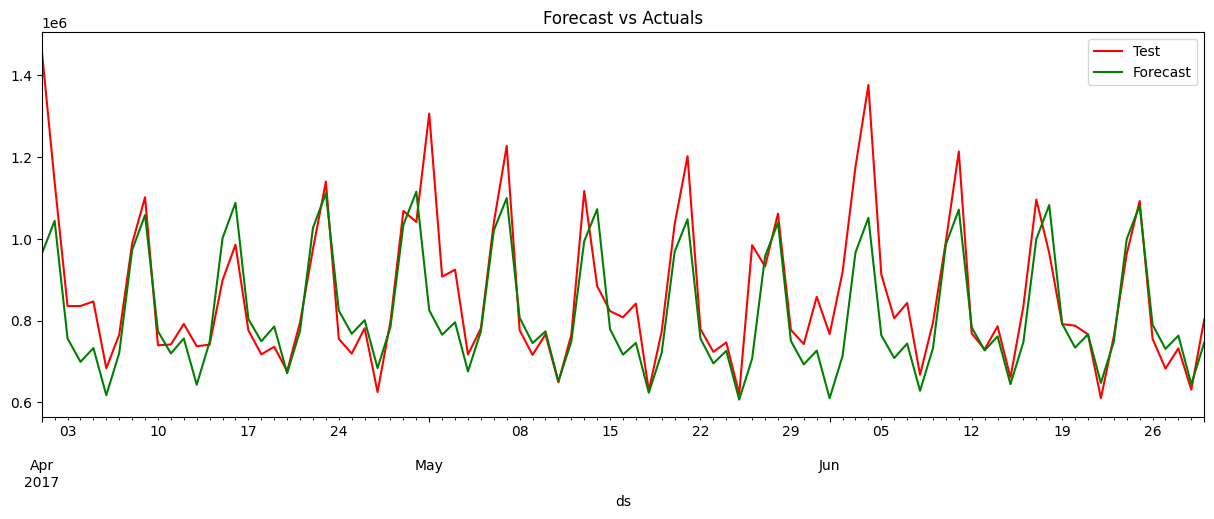

In [50]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()